In [1]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
# enable plotly notebook mode
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [3]:
# adjust max rows
pd.set_option("max_rows", 200)

## Data Import and Light Cleaning

In [4]:
# import scraped data
data = pd.read_csv("./scrape_output/Extracted_From_Indeed_011922.csv")

# import us states and codes
statecodes = pd.read_csv("./input_files/us-states-and-codes.csv")

In [5]:
# preview data
data.head(5)

,us_state,search_term,position_location,num_of_jobs,search_string,job_count
0,Alabama,title:(data engineer),data engineer jobs in Alabama,Page 1 of 81 jobs,Data Engineer,81
1,Alabama,title:(data scientist),data scientist jobs in Alabama,Page 1 of 31 jobs,Data Scientist,31
2,Alabama,title:(data analyst),data analyst jobs in Alabama,Page 1 of 87 jobs,Data Analyst,87
3,Alaska,title:(data engineer),data engineer jobs in Alaska,Page 1 of 17 jobs,Data Engineer,17
4,Alaska,title:(data scientist),data scientist jobs in Alaska,Page 1 of 1 jobs,Data Scientist,1


In [6]:
# describe data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   us_state           150 non-null    object
 1   search_term        150 non-null    object
 2   position_location  150 non-null    object
 3   num_of_jobs        150 non-null    object
 4   search_string      150 non-null    object
 5   job_count          150 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 7.2+ KB


In [7]:
# remove columns not needed
data2 = data.drop(columns=["search_term", "position_location", "num_of_jobs"])

# drop data analyst records from this rudimentary analysis since it's more of an umbrella term
data2 = data2[data2["search_string"] != "Data Analyst"].copy()

## Display Raw Data in a Pivot Table

In [8]:
# pivot the data
pivoted = data2.pivot_table(
    index="us_state",
    columns="search_string",
    values="job_count",
    aggfunc="sum"
).reset_index()

# compare data engineer and data scientist vacancy counts
pivoted["More Engineers"] = pivoted["Data Engineer"] > pivoted["Data Scientist"]

# rename columns
pivoted = pivoted.rename(columns={
    "us_state": "US State",
    "Data Engineer": "Data Engineer Vacancies",
    "Data Scientist": "Data Scientist Vacancies"
})

In [9]:
# display entire table
pivoted

search_string,US State,Data Engineer Vacancies,Data Scientist Vacancies,More Engineers
0,Alabama,81,31,True
1,Alaska,17,1,True
2,Arizona,334,94,True
3,Arkansas,61,51,True
4,California,3342,1620,True
5,Colorado,252,120,True
6,Connecticut,242,102,True
7,Delaware,72,26,True
8,Florida,606,269,True
9,Georgia,535,295,True


In [10]:
# do all states have more data engineer vacancies than data scientist vacancies?
pivoted["More Engineers"].all()

True

## Plot Absolute Values on a Choropleth Map

In [11]:
# plotly express choropleth maps tutorial: https://plotly.com/python/choropleth-maps/
# plotly express choropleth maps documentation: https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html

In [12]:
# assign us state codes to the states in pivoted
pivoted = pivoted.merge(
    statecodes,
    left_on="US State",
    right_on="State",
    how="left"
)

# drop redundant state column
pivoted = pivoted.drop(columns=["State"])

### Data Engineering Vacancies

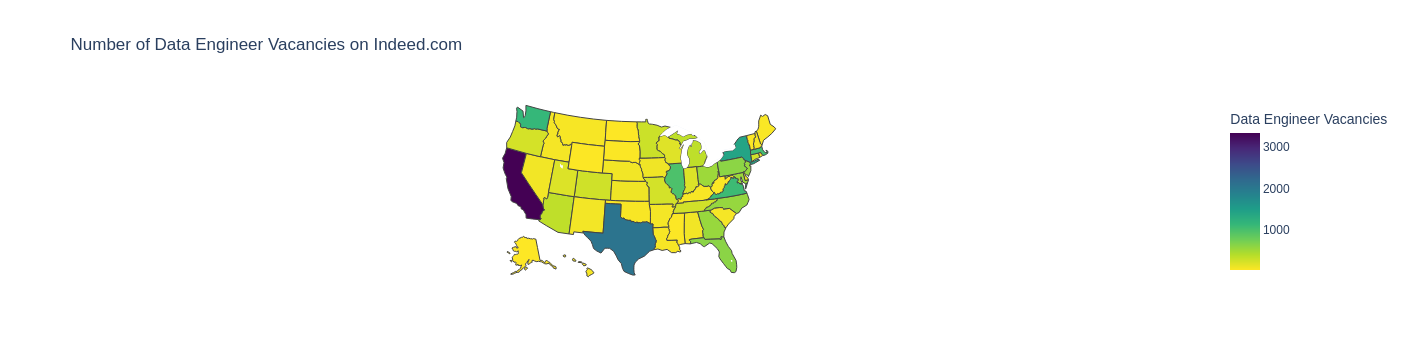

In [13]:
# plot data engineering vacancies in an interactive chart
fig = px.choropleth(
    data_frame=pivoted,
    locations="Alpha code",
    locationmode="USA-states",
    color="Data Engineer Vacancies",
    scope="usa",
    color_continuous_scale="viridis_r",
    title="Number of Data Engineer Vacancies on Indeed.com"
)

fig.show()

### Data Scientist Vacancies

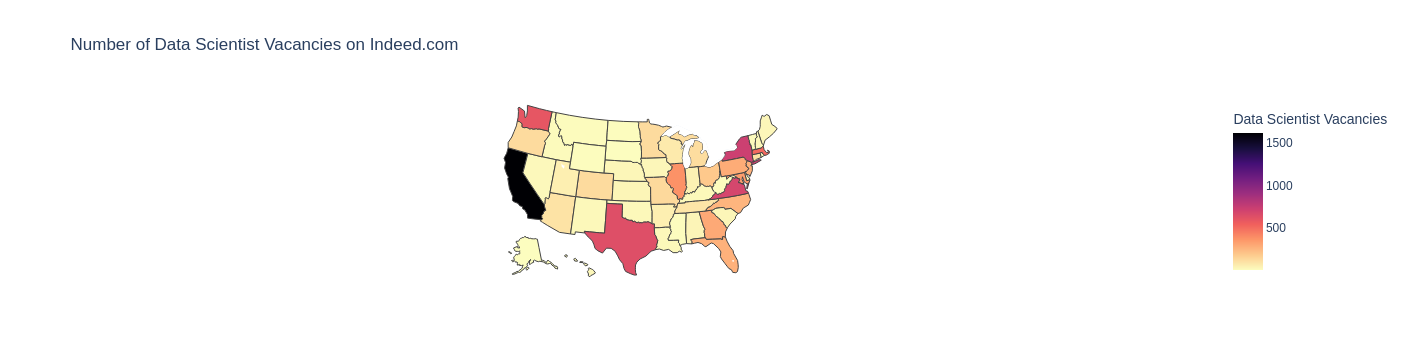

In [14]:
# plot data scientist vacancies in an interactive chart
fig = px.choropleth(
    data_frame=pivoted,
    locations="Alpha code",
    locationmode="USA-states",
    color="Data Scientist Vacancies",
    scope="usa",
    color_continuous_scale="magma_r",
    title="Number of Data Scientist Vacancies on Indeed.com"
)

fig.show()

## Plot Difference on a Choropleth Map

In [15]:
# calculate difference (i.e., there are x many times data engineer vacancies than data scientist vacancies)
pivoted["Difference"] = pivoted["Data Engineer Vacancies"] / pivoted["Data Scientist Vacancies"]

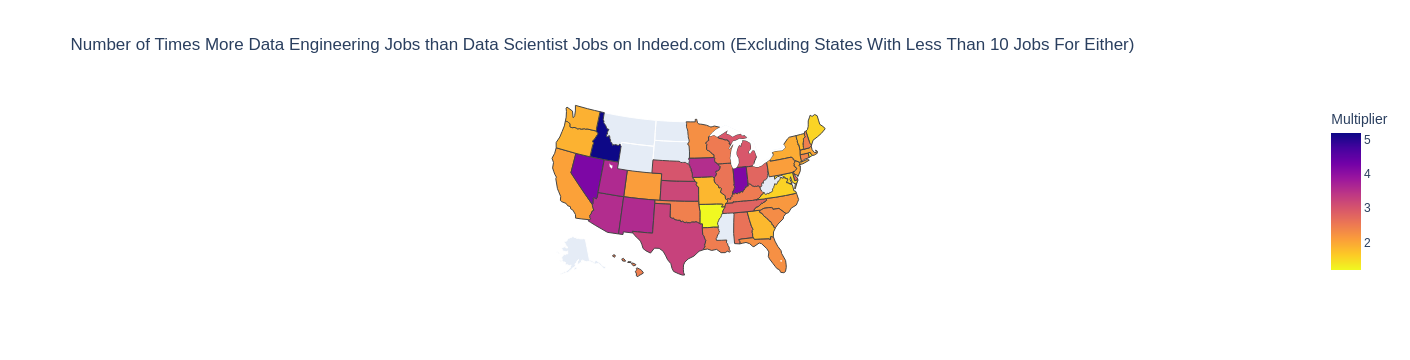

In [16]:
# plot difference in an interactive chart
# exclude states with less than X of either job (exlcuding outliers that skew the colors)
LIMITER = 10
fig = px.choropleth(
    data_frame=pivoted[(pivoted["Data Scientist Vacancies"] > LIMITER) & (pivoted["Data Engineer Vacancies"] > LIMITER)],
    locations="Alpha code",
    locationmode="USA-states",
    color="Difference",
    scope="usa",
    color_continuous_scale="plasma_r",
    title=f"Number of Times More Data Engineering Jobs than Data Scientist Jobs on Indeed.com (Excluding States With Less Than {LIMITER} Jobs For Either)",
    labels={"Difference": "Multiplier"}
)

fig.show()

---